In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
import networkx as nx

import matplotlib as mpl
from matplotlib import cm
from matplotlib.patches import Circle, Wedge, Polygon
from scipy.spatial.distance import cdist

from ipywidgets import interactive

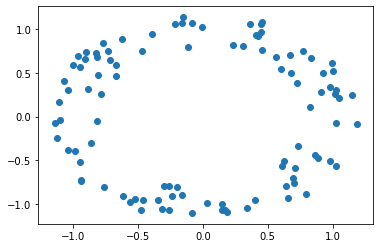

In [3]:
N = 100

r = np.random.uniform(-0.2, 0.2, N) # radious
theta = np.random.uniform(-np.pi, np.pi, N) # angles

x = (1+r)*np.cos(theta) # x-corodinate
y = (1+r)*np.sin(theta) # y-coordinate

X = np.column_stack((x,y)) # data set

plt.scatter(X[:,0], X[:,1])

In [4]:
distance_matrix = cdist(X,X)

In [5]:
# dist_m = distance matrix
# n = number of landmarks
def minmax(dist_m, n):
    L = [np.random.randint(0,len(X))]
    
    dist_to_L = dist_m[ L[-1] ,:]
    
    for i in range(n-1):
        ind = np.argmax( dist_to_L )
        L.append(ind)
        
        dist_to_L = np.minimum(dist_to_L, dist_m[L[-1], :])

    return L, np.max(dist_to_L) + 0.001

Covering radius =  0.45061849279849936


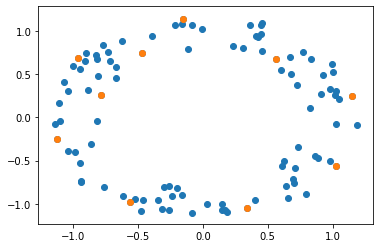

In [10]:
#landamrks contains the indices of the landmark points
#c_r is the minimal covering radious for the landmark set computed.
landmarks, c_r = minmax(distance_matrix, 10) 

print('Covering radius = ', c_r)

# plot
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[landmarks,0], X[landmarks,1])

In [11]:
# Rips complex
def rips_complex(dist_m, alpha):
    
    D = copy.deepcopy(dist_m)
    
    R = {}
    # 0-simplices
    R['0'] = np.arange(0,len(dist_m))
    
    D[D > alpha] = 0

    non_zero = np.nonzero(D)
    # 1-simplices
    R['1'] = []
    for j in itertools.combinations( np.arange(len(dist_m)), 2 ):
        ind = np.array(j)
        if np.max(dist_m[ind,:][:,ind]) < alpha:
            R['1'].append(ind)
    
    # 2-simplices
    R['2'] = []
    for j in itertools.combinations( np.arange(len(dist_m)), 3 ):
        ind = np.array(j)
        if np.max(dist_m[ind,:][:,ind]) < alpha:
            R['2'].append(ind)

    return R

# Nerve-like complex
def intersection(dist_m, land_ind, epsilon):
    
    distance_to_landmarks = dist_m[land_ind,:]
    
    N = {}
    N['0'] = np.arange(0,len(distance_to_landmarks))
    
    adj_points = np.zeros((len(N['0']), len(N['0'])))
    N['1'] = []
    for j in itertools.combinations( np.arange(len(distance_to_landmarks)), 2 ):
        ind = np.array(j)
        in_ball = distance_to_landmarks[ ind ,:] < epsilon
        if np.logical_and(in_ball[0,:], in_ball[1,:]).any():
            N['1'].append(ind)
            adj_points[ind[0],ind[1]] = np.sum(np.logical_and(in_ball[0,:], in_ball[1,:]))
            adj_points[ind[1],ind[0]] = adj_points[ind[0],ind[1]]
            
    N['2'] = []
    for j in itertools.combinations( np.arange(len(distance_to_landmarks)), 3 ):
        ind = np.array(j)
        in_ball = distance_to_landmarks[ ind ,:] < epsilon
        if np.logical_and(np.logical_and(in_ball[0,:], in_ball[1,:]),in_ball[2,:]).any():
            N['2'].append(ind)
            
    return adj_points, N

In [12]:
# This function generates the slider visualization.
def interactive_plot(alpha):
    landmark_set = X[landmarks,:]
    
    R_a = rips_complex(distance_matrix[landmarks,:][:,landmarks], alpha)
    
    w_by_intersection, N = intersection(distance_matrix, landmarks, alpha)
    
    fig, ax = plt.subplots(2,2, figsize=(30,30))
    
    ax = ax.flatten()
    
    ax[2].scatter(landmark_set[:,0], landmark_set[:,1], c='black')
    ax[2].set_title('Nerve complex')
    for edge in N['1']:
        ax[2].plot(landmark_set[edge,0], landmark_set[edge,1], c='blue')

    for face in N['2']:
        pol = Polygon(landmark_set[face,:], closed=True, color='cyan')
        ax[2].add_patch(pol)
    
    ax[3].scatter(landmark_set[:,0], landmark_set[:,1], c='black')
    ax[3].set_title('Rips complex')
    for edge in R_a['1']:
        ax[3].plot(landmark_set[edge,0], landmark_set[edge,1], c='blue')

    for face in R_a['2']:
        pol = Polygon(landmark_set[face,:], closed=True, color='cyan')
        ax[3].add_patch(pol)

    ax[0].scatter(X[:,0], X[:,1], c='black')
    ax[0].scatter(landmark_set[:,0], landmark_set[:,1], c='red')
    ax[0].set_ylim(-1-alpha,1+alpha)
    ax[0].set_xlim(-1-alpha,1+alpha)
    ax[0].set_title('Nerve cover')
    
    for point in range(len(landmarks)):
        cir = Circle((landmark_set[point,0], landmark_set[point,1]), alpha, color=(1,0,0,0.2))
        ax[0].add_patch(cir)
        
    ax[1].scatter(X[:,0], X[:,1], c='black')
    ax[1].scatter(landmark_set[:,0], landmark_set[:,1], c='red')
    ax[1].set_ylim(-1-alpha,1+alpha)
    ax[1].set_xlim(-1-alpha,1+alpha)
    ax[1].set_title('Rips cover')
    
    for point in range(len(landmarks)):
        cir = Circle((landmark_set[point,0], landmark_set[point,1]), alpha/2, color=(1,0,0,0.2))
        ax[1].add_patch(cir)
        
inter = interactive(interactive_plot, alpha=(0,2,0.05))
output = inter.children[-1]
inter

interactive(children=(FloatSlider(value=1.0, description='alpha', max=2.0, step=0.05), Output()), _dom_classes…